In [3]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from utils import load_series_dfs
import pickle
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from scipy.signal import periodogram
import logging
from sklearn.preprocessing import StandardScaler
import itertools
import numpy as np

In [2]:
series_dfs = load_series_dfs(data_dir=r"C:\Users\johan\Documents\FH_Master\data", filename="final_learning_dfs.pkl")
series_dfs['FL_00024702.PLAN.MengeHH'].columns

Index(['consumption', 'hour', 'weekday', 'month', 'is_weekend', 'w_tl', 'w_rf',
       'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm', 'w_tb10',
       'w_tb20', 'CEGH_WAP', 'THE_WAP'],
      dtype='object')

In [3]:
start, end = series_dfs['FL_00024702.PLAN.MengeHH'].index.min(), series_dfs['FL_00024702.PLAN.MengeHH'].index.max()
start, end

(Timestamp('2015-01-01 06:00:00'), Timestamp('2018-12-31 23:00:00'))

In [5]:
def adf_test(ts):
    """Führt den ADF-Test durch und liefert eine dict mit den Ergebnissen."""
    result = adfuller(ts.dropna())
    return {
        'adf_statistic': result[0],
        'p_value': result[1],
        'crit_1%': result[4]['1%'],
        'crit_5%': result[4]['5%'],
        'crit_10%': result[4]['10%']
    }

# Schleife über alle Serien im Dictionary
results = []
for name, series in series_dfs.items():
    res = adf_test(series_dfs[name]['consumption'])
    res['series_key'] = name
    results.append(res)

# Ergebnisse in DataFrame umwandeln
results_df = pd.DataFrame(results).set_index('series_key')

# Stationaritätsentscheidung hinzufügen
results_df['stationary (p < 0.05)'] = results_df['p_value'] < 0.05

# Ergebnisse anzeigen
results_df

#to-do nochmal nachprüfen null hypothese stationät???

,adf_statistic,p_value,crit_1%,crit_5%,crit_10%,stationary (p < 0.05)
series_key,,,,,,
FL_00024702.PLAN.MengeHH,-3.372787,1.192230e-02,-3.430536,-2.861622,-2.566814,True
FL_00024730.PLAN.MengeHH,-15.233975,5.273878e-28,-3.430536,-2.861622,-2.566814,True
FL_00352243.PLAN.MengeHH,-7.726360,1.156205e-11,-3.430536,-2.861622,-2.566814,True
FL_00352244.PLAN.MengeGA,-6.279340,3.830541e-08,-3.430536,-2.861622,-2.566814,True
FL_00352244.PLAN.MengeKW,-7.473581,4.980813e-11,-3.430536,-2.861622,-2.566814,True
FL_00024360.PLAN.MengeGA,-15.039158,9.649820e-28,-3.430536,-2.861622,-2.566814,True
FL_00352254.PLAN.MengeGA,-12.388359,4.851672e-23,-3.430536,-2.861622,-2.566814,True
FL_00025248.PLAN.MengeGA,-12.146135,1.609178e-22,-3.430536,-2.861622,-2.566814,True
FL_00024360.PLAN.MengeHH.2,-11.910003,5.324208e-22,-3.430536,-2.861622,-2.566814,True


In [4]:
df = series_dfs['FL_00024702.PLAN.MengeHH']

df.index = pd.to_datetime(df.index)
df = df.sort_index()
# 1) Dubletten raushauen (oder vorher groupby mean)
df = df[~df.index.duplicated(keep='first')]

# 2) Sortieren
df = df.sort_index()

# 3) Resample und interpolieren – Index wird gesetzt und freq='h' hinterlegt
df = df.resample('h').interpolate()

# 4) (Optional) nochmal explizit asfreq, freq ist aber schon da
df = df.asfreq('h')

print(df.index.freq)

# Optional: Regressoren standardisieren
features = ['hour', 'weekday', 'month', 'is_weekend', 'w_tl', 'w_rf',
            'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm',
            'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP']

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

<Hour>


In [4]:
import logging
import numpy as np
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 24
best_aic = np.inf
best_params = None
i = 0
for param in itertools.product(p, [0], q):
    print("erste ebene: param = {}".format(param))
    for param_seasonal in itertools.product(P, [0], Q, [s]):
        print("zweite ebene: param_seasonal = {}".format(param_seasonal))
        try:
           i = i + 1
        except:
            continue

print("Best AIC:", best_aic)
print("Best params:", best_params)

print(i)

erste ebene: param = (0, 0, 0)
zweite ebene: param_seasonal = (0, 0, 0, 24)
zweite ebene: param_seasonal = (0, 0, 1, 24)
zweite ebene: param_seasonal = (1, 0, 0, 24)
zweite ebene: param_seasonal = (1, 0, 1, 24)
erste ebene: param = (0, 0, 1)
zweite ebene: param_seasonal = (0, 0, 0, 24)
zweite ebene: param_seasonal = (0, 0, 1, 24)
zweite ebene: param_seasonal = (1, 0, 0, 24)
zweite ebene: param_seasonal = (1, 0, 1, 24)
erste ebene: param = (0, 0, 2)
zweite ebene: param_seasonal = (0, 0, 0, 24)
zweite ebene: param_seasonal = (0, 0, 1, 24)
zweite ebene: param_seasonal = (1, 0, 0, 24)
zweite ebene: param_seasonal = (1, 0, 1, 24)
erste ebene: param = (1, 0, 0)
zweite ebene: param_seasonal = (0, 0, 0, 24)
zweite ebene: param_seasonal = (0, 0, 1, 24)
zweite ebene: param_seasonal = (1, 0, 0, 24)
zweite ebene: param_seasonal = (1, 0, 1, 24)
erste ebene: param = (1, 0, 1)
zweite ebene: param_seasonal = (0, 0, 0, 24)
zweite ebene: param_seasonal = (0, 0, 1, 24)
zweite ebene: param_seasonal = (1, 

In [4]:
import logging
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 24
best_aic = np.inf
best_params = None

for param in itertools.product(p, [0], q):
    print("erste ebene: param = {}".format(param))
    for param_seasonal in itertools.product(P, [0], Q, [s]):
        print("zweite ebene: param_seasonal = {}".format(param_seasonal))
        try:
            mod = SARIMAX(df['consumption'],
                          exog=df[features],
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=True,
                          enforce_invertibility=True)
            res = mod.fit(disp=False,
                          method='powell',
                          maxiter=300)
            if res.aic < best_aic:
                best_aic = res.aic
                best_params = (param, param_seasonal)
        except:
            continue

print("Best AIC:", best_aic)
print("Best params:", best_params)

erste ebene: param = (0, 0, 0)
zweite ebene: param_seasonal = (0, 0, 0, 24)
zweite ebene: param_seasonal = (0, 0, 1, 24)
zweite ebene: param_seasonal = (1, 0, 0, 24)
zweite ebene: param_seasonal = (1, 0, 1, 24)
erste ebene: param = (0, 0, 1)
zweite ebene: param_seasonal = (0, 0, 0, 24)


C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


zweite ebene: param_seasonal = (0, 0, 1, 24)


C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


zweite ebene: param_seasonal = (1, 0, 0, 24)


C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


zweite ebene: param_seasonal = (1, 0, 1, 24)


C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


erste ebene: param = (0, 0, 2)
zweite ebene: param_seasonal = (0, 0, 0, 24)


C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


zweite ebene: param_seasonal = (0, 0, 1, 24)


C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


zweite ebene: param_seasonal = (1, 0, 0, 24)


C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


zweite ebene: param_seasonal = (1, 0, 1, 24)


C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


erste ebene: param = (1, 0, 0)
zweite ebene: param_seasonal = (0, 0, 0, 24)
zweite ebene: param_seasonal = (0, 0, 1, 24)
zweite ebene: param_seasonal = (1, 0, 0, 24)
zweite ebene: param_seasonal = (1, 0, 1, 24)
erste ebene: param = (1, 0, 1)
zweite ebene: param_seasonal = (0, 0, 0, 24)
zweite ebene: param_seasonal = (0, 0, 1, 24)
zweite ebene: param_seasonal = (1, 0, 0, 24)
zweite ebene: param_seasonal = (1, 0, 1, 24)
erste ebene: param = (1, 0, 2)
zweite ebene: param_seasonal = (0, 0, 0, 24)
zweite ebene: param_seasonal = (0, 0, 1, 24)
zweite ebene: param_seasonal = (1, 0, 0, 24)
zweite ebene: param_seasonal = (1, 0, 1, 24)
erste ebene: param = (2, 0, 0)
zweite ebene: param_seasonal = (0, 0, 0, 24)
zweite ebene: param_seasonal = (0, 0, 1, 24)
zweite ebene: param_seasonal = (1, 0, 0, 24)
zweite ebene: param_seasonal = (1, 0, 1, 24)
erste ebene: param = (2, 0, 1)
zweite ebene: param_seasonal = (0, 0, 0, 24)
zweite ebene: param_seasonal = (0, 0, 1, 24)
zweite ebene: param_seasonal = (1, 

In [4]:
model_best = SARIMAX(
    df['consumption'],
    exog=df[features],
    order=(1, 0, 2),
    seasonal_order=(1, 0, 1, 24),
    enforce_stationarity=True,
    enforce_invertibility=True
)
results_best = model_best.fit(disp=False, method='powell',
                          maxiter=300)

print(results_best.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          consumption   No. Observations:                35058
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 24)   Log Likelihood              -44198.965
Date:                              Sat, 26 Jul 2025   AIC                          88441.930
Time:                                      15:53:47   BIC                          88628.154
Sample:                                  01-01-2015   HQIC                         88501.242
                                       - 12-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hour          -0.0762      0.605     -0.126      0.900      -1.262       1.109
weekday       -0.07

In [5]:
to_drop = ['hour', 'month', 'is_weekend', 'w_rr', 'weekday']

In [8]:

keep = ['w_tl','w_rf','w_ff','w_ffx',
        'w_cglo','w_so_h','w_rrm','w_tb10','w_tb20',
        'CEGH_WAP','THE_WAP']
exog_sig = df[keep]

In [9]:
model_red = SARIMAX(df['consumption'],
                    exog=exog_sig,
                    order=(1,0,2),
                    seasonal_order=(1,0,1,24),
                    enforce_stationarity=True,
                    enforce_invertibility=True)
res_red = model_red.fit(disp=False, method='powell', maxiter=300)
print(res_red.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          consumption   No. Observations:                35058
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 24)   Log Likelihood              -44207.900
Date:                              Sat, 26 Jul 2025   AIC                          88449.800
Time:                                      16:26:59   BIC                          88593.701
Sample:                                  01-01-2015   HQIC                         88495.632
                                       - 12-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
w_tl          -2.1277      0.081    -26.299      0.000      -2.286      -1.969
w_rf          -0.18

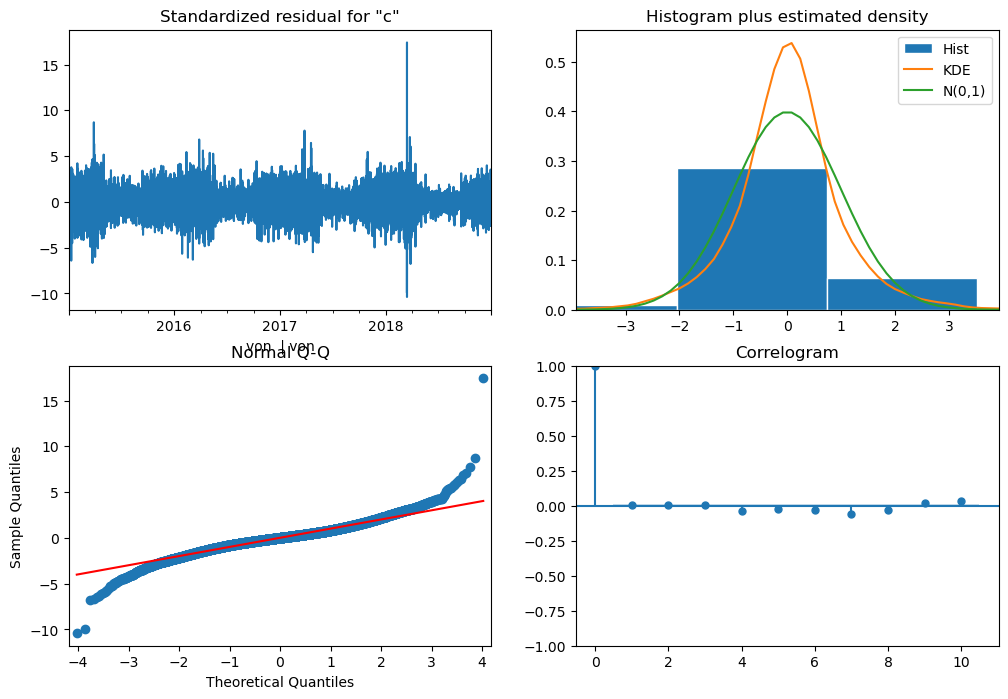

In [10]:
results_best.plot_diagnostics(figsize=(12, 8));

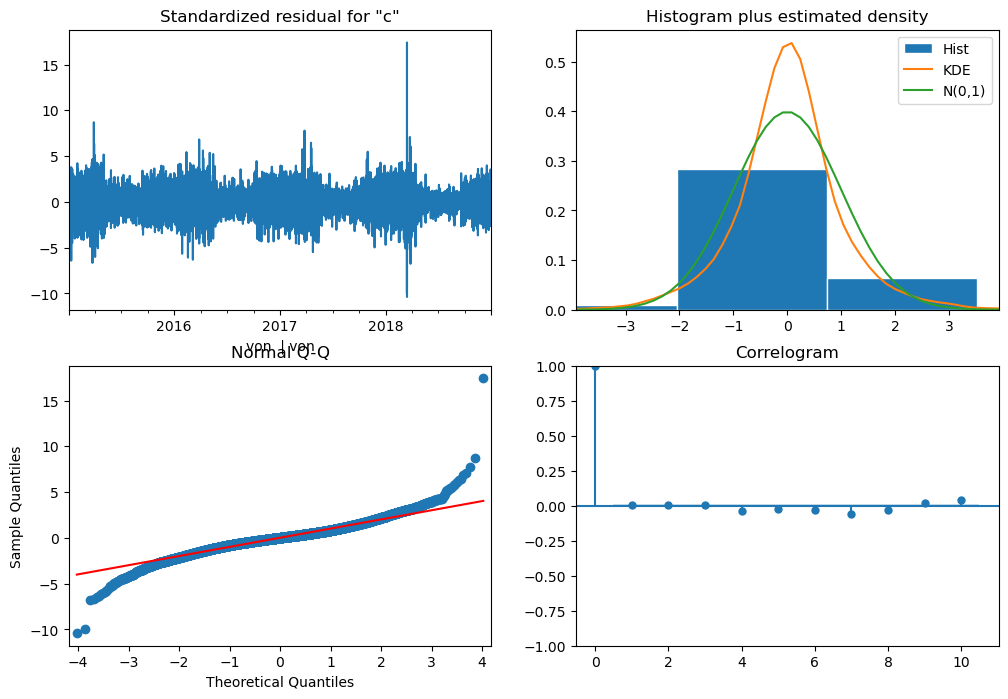

In [12]:
res_red.plot_diagnostics(figsize=(12, 8));

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Split in Training (bis 2017-12-31) und Test (2018)
train = df.loc[:'2017-12-31']
test  = df.loc['2018-01-01':]

# 2. Definiere Exogene für Full und Reduced
features_full = ['hour', 'weekday', 'month', 'is_weekend',
                 'w_tl','w_rf','w_ff','w_ffx','w_cglo',
                 'w_so_h','w_rr','w_rrm','w_tb10','w_tb20',
                 'CEGH_WAP','THE_WAP']

features_red  = ['w_tl','w_rf','w_ff','w_ffx',
                 'w_cglo','w_so_h','w_rrm',
                 'w_tb10','w_tb20','CEGH_WAP','THE_WAP']

# 3. Fit beider Modelle auf den Trainingsdaten
mod_full = SARIMAX(
    train['consumption'],
    exog=train[features_full],
    order=(1,0,2),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=True,
    enforce_invertibility=True
)
res_full = mod_full.fit(disp=False, method='powell', maxiter=300)

mod_red = SARIMAX(
    train['consumption'],
    exog=train[features_red],
    order=(1,0,2),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=True,
    enforce_invertibility=True
)
res_red = mod_red.fit(disp=False, method='powell', maxiter=300)

# 4. Forecast auf Testdaten generieren
#    (Schrittweite = Länge des Test-Sets)
n_test = len(test)

pred_full = res_full.get_forecast(steps=n_test, exog=test[features_full])
yhat_full = pred_full.predicted_mean

pred_red  = res_red.get_forecast(steps=n_test, exog=test[features_red])
yhat_red  = pred_red.predicted_mean

# 5. Fehlerberechnung
y_true = test['consumption']

rmse_full = mean_squared_error(y_true, yhat_full, squared=False)
mae_full  = mean_absolute_error(y_true, yhat_full)

rmse_red  = mean_squared_error(y_true, yhat_red, squared=False)
mae_red   = mean_absolute_error(y_true, yhat_red)

# 6. Ergebnisse ausgeben
print("=== Full Model ===")
print(f"RMSE: {rmse_full:.2f}")
print(f"MAE : {mae_full:.2f}\n")

print("=== Reduced Model ===")
print(f"RMSE: {rmse_red:.2f}")
print(f"MAE : {mae_red:.2f}")

TypeError: got an unexpected keyword argument 'squared'

In [14]:
# 1) wahrer Wert und Vorhersage als NumPy-Arrays (NaNs an Anfang entfernen, falls nötig)
y_true = test['consumption'].values
yhat_full = yhat_full.values
yhat_red  = yhat_red.values

# 2) MSE und RMSE berechnen
mse_full = mean_squared_error(y_true, yhat_full)
rmse_full = np.sqrt(mse_full)
mae_full = mean_absolute_error(y_true, yhat_full)

mse_red  = mean_squared_error(y_true, yhat_red)
rmse_red  = np.sqrt(mse_red)
mae_red   = mean_absolute_error(y_true, yhat_red)

# 3) Ausgabe
print("=== Full Model ===")
print(f"RMSE: {rmse_full:.2f}")
print(f"MAE : {mae_full:.2f}\n")

print("=== Reduced Model ===")
print(f"RMSE: {rmse_red:.2f}")
print(f"MAE : {mae_red:.2f}")

=== Full Model ===
RMSE: 6.19
MAE : 4.78

=== Reduced Model ===
RMSE: 6.10
MAE : 4.73


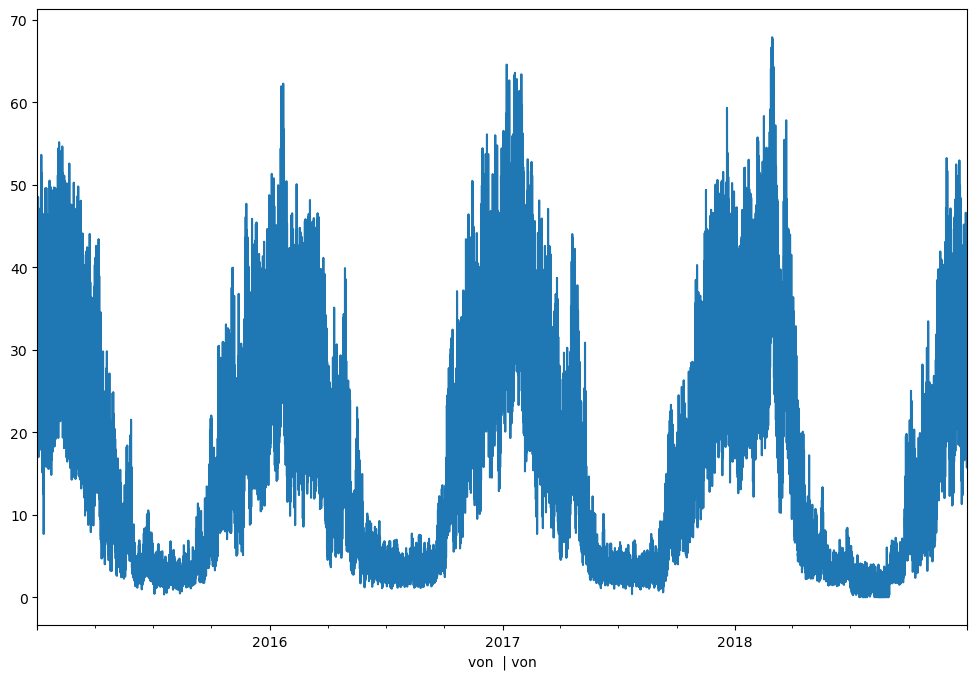

In [15]:
df.consumption.plot(figsize=(12, 8));

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Naive-Vorhersage: Verbrauch vor 24h
y_naive = test['consumption'].shift(24).dropna()
y_true_naive = test['consumption'].loc[y_naive.index]

rmse_naive = np.sqrt(mean_squared_error(y_true_naive, y_naive))
mae_naive  = mean_absolute_error(y_true_naive, y_naive)

print("=== Naive 24h-Lag ===")
print(f"RMSE: {rmse_naive:.2f}")
print(f"MAE : {mae_naive:.2f}")

=== Naive 24h-Lag ===
RMSE: 2.76
MAE : 1.79


In [20]:
# Naive-Vorhersage: Verbrauch vor 48h
y_naive = test['consumption'].shift(48).dropna()
y_true_naive = test['consumption'].loc[y_naive.index]

rmse_naive = np.sqrt(mean_squared_error(y_true_naive, y_naive))
mae_naive  = mean_absolute_error(y_true_naive, y_naive)

print("=== Naive 48h-Lag ===")
print(f"RMSE: {rmse_naive:.2f}")
print(f"MAE : {mae_naive:.2f}")

=== Naive 48h-Lag ===
RMSE: 3.68
MAE : 2.41


In [19]:
# Naive-Vorhersage: Verbrauch vor 24h
y_naive = test['consumption'].shift(62).dropna()
y_true_naive = test['consumption'].loc[y_naive.index]

rmse_naive = np.sqrt(mean_squared_error(y_true_naive, y_naive))
mae_naive  = mean_absolute_error(y_true_naive, y_naive)

print("=== Naive 62h-Lag ===")
print(f"RMSE: {rmse_naive:.2f}")
print(f"MAE : {mae_naive:.2f}")

=== Naive 62h-Lag ===
RMSE: 8.98
MAE : 6.08


In [23]:
# Die Horizont-Werte, für die du die Naive-Metriken schon ermittelt hast:
horizons = [24, 48, 62]

# Dictionaries, um die Ergebnisse abzuspeichern
rmse_model = {}
mae_model = {}

for h in horizons:
    # 1) slice der exogenen Features für genau h Stunden ab Test-Beginn
    exog_future = test[features_red].iloc[:h]

    # 2) h-Schritt-Vorhersage ab Ende Training
    pred = res_red.get_forecast(steps=h, exog=exog_future)
    yhat = pred.predicted_mean

    # 3) wahre Werte der ersten h Stunden im Test
    ytrue = test['consumption'].iloc[:h]

    # 4) Fehlermaße
    rmse_model[h] = np.sqrt(mean_squared_error(ytrue, yhat))
    mae_model[h]  = mean_absolute_error(ytrue, yhat)

# 5) Ausgabe
print("=== Modell-Fehler pro Horizon ===")
for h in horizons:
    print(f"{h:2d}h-Vorhorizont:   RMSE = {rmse_model[h]:.2f},  MAE = {mae_model[h]:.2f}")

=== Modell-Fehler pro Horizon ===
24h-Vorhorizont:   RMSE = 1.73,  MAE = 1.23
48h-Vorhorizont:   RMSE = 1.68,  MAE = 1.30
62h-Vorhorizont:   RMSE = 1.74,  MAE = 1.35


In [43]:

# 1) Definiere deine Horizonts
horizons = [6, 24, 48, 62]

# 2) Bereite die Training/Endpunkt für Forecast vor
train_end = '2017-12-31 23:00:00'
test_start = pd.to_datetime(train_end) + pd.Timedelta(hours=1)

# 3) Loop über alle Horizonts und berechne RMSE/MAE für Naive und SARIMAX
results = []

for h in horizons:
    # a) die ersten h Zeitpunkte im Test
    idx_h = pd.date_range(start=test_start, periods=h, freq='h')

    # b) True Values
    y_true = df['consumption'].loc[idx_h]

    # c) Naive Seasonal (24h-Lag) Baseline
    y_naive = df['consumption'].shift(24).loc[idx_h]

    # d) SARIMAX-Forecast
    exog_future = df[features_red].loc[idx_h]
    pred = res_red.get_forecast(steps=h, exog=exog_future)
    yhat = pred.predicted_mean.loc[idx_h]

    # e) Fehlerberechnung
    rmse_naive = np.sqrt(mean_squared_error(y_true, y_naive))
    mae_naive  = mean_absolute_error(y_true, y_naive)
    rmse_model = np.sqrt(mean_squared_error(y_true, yhat))
    mae_model  = mean_absolute_error(y_true, yhat)

    results.append({
        'horizon':     h,
        'rmse_naive':  rmse_naive,
        'mae_naive':   mae_naive,
        'rmse_sarimax':rmse_model,
        'mae_sarimax': mae_model
    })

# 4) Ergebnisse anzeigen
import pandas as pd
cmp = pd.DataFrame(results).set_index('horizon')
print(cmp)

         rmse_naive  mae_naive  rmse_sarimax  mae_sarimax
horizon                                                  
6          3.068862   2.028333      0.582528     0.479985
24         4.764512   3.911292      1.757947     1.240472
48         3.793429   2.882146      1.686266     1.300895
62         3.543759   2.711806      1.734604     1.344455


In [39]:
# 1. Split in Training (bis 2017-12-31) und Test (2018)
train = df.loc[:'2016-12-31']
test  = df.loc['2017-01-01':'2017-12-31']

# 2. Definiere Exogene für Full und Reduced
features_full = ['hour', 'weekday', 'month', 'is_weekend',
                 'w_tl','w_rf','w_ff','w_ffx','w_cglo',
                 'w_so_h','w_rr','w_rrm','w_tb10','w_tb20',
                 'CEGH_WAP','THE_WAP']

features_red  = ['w_tl','w_rf','w_ff','w_ffx',
                 'w_cglo','w_so_h','w_rrm',
                 'w_tb10','w_tb20','CEGH_WAP','THE_WAP']

# 3. Fit beider Modelle auf den Trainingsdaten
mod_full = SARIMAX(
    train['consumption'],
    exog=train[features_full],
    order=(1,0,2),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=True,
    enforce_invertibility=True
)
res_full = mod_full.fit(disp=False, method='powell', maxiter=300)

mod_red = SARIMAX(
    train['consumption'],
    exog=train[features_red],
    order=(1,0,2),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=True,
    enforce_invertibility=True
)
res_red = mod_red.fit(disp=False, method='powell', maxiter=300)

# 4. Forecast auf Testdaten generieren
#    (Schrittweite = Länge des Test-Sets)
n_test = len(test)

pred_full = res_full.get_forecast(steps=n_test, exog=test[features_full])
yhat_full = pred_full.predicted_mean

pred_red  = res_red.get_forecast(steps=n_test, exog=test[features_red])
yhat_red  = pred_red.predicted_mean


y_true = test['consumption'].values
yhat_full = yhat_full.values
yhat_red  = yhat_red.values


mse_full = mean_squared_error(y_true, yhat_full)
rmse_full = np.sqrt(mse_full)
mae_full = mean_absolute_error(y_true, yhat_full)

mse_red  = mean_squared_error(y_true, yhat_red)
rmse_red  = np.sqrt(mse_red)
mae_red   = mean_absolute_error(y_true, yhat_red)

# 3) Ausgabe
print("=== Full Model ===")
print(f"RMSE: {rmse_full:.2f}")
print(f"MAE : {mae_full:.2f}\n")

print("=== Reduced Model ===")
print(f"RMSE: {rmse_red:.2f}")
print(f"MAE : {mae_red:.2f}")

=== Full Model ===
RMSE: 6.77
MAE : 5.50

=== Reduced Model ===
RMSE: 9.03
MAE : 7.12


In [37]:
train = df.loc[:'2016-12-31']
test  = df.loc['2017-01-01':'2017-12-31']

train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2015-01-01 06:00:00'),
 Timestamp('2016-12-31 23:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-12-31 23:00:00'))

In [38]:
len(train), len(test)

(17538, 8760)

In [41]:
train = df.loc['2016-01-01':'2017-12-31']
test  = df.loc['2018-01-01':]

train.index.min(), train.index.max(), test.index.min(), test.index.max(), len(train), len(test)

(Timestamp('2016-01-01 00:00:00'),
 Timestamp('2017-12-31 23:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-12-31 23:00:00'),
 17544,
 8760)

In [42]:
# 1. Split in Training (bis 2017-12-31) und Test (2018)
train = df.loc['2016-01-01':'2017-12-31']
test  = df.loc['2018-01-01':]

# 2. Definiere Exogene für Full und Reduced
features_full = ['hour', 'weekday', 'month', 'is_weekend',
                 'w_tl','w_rf','w_ff','w_ffx','w_cglo',
                 'w_so_h','w_rr','w_rrm','w_tb10','w_tb20',
                 'CEGH_WAP','THE_WAP']

features_red  = ['w_tl','w_rf','w_ff','w_ffx',
                 'w_cglo','w_so_h','w_rrm',
                 'w_tb10','w_tb20','CEGH_WAP','THE_WAP']

# 3. Fit beider Modelle auf den Trainingsdaten
mod_full = SARIMAX(
    train['consumption'],
    exog=train[features_full],
    order=(1,0,2),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=True,
    enforce_invertibility=True
)
res_full = mod_full.fit(disp=False, method='powell', maxiter=300)

mod_red = SARIMAX(
    train['consumption'],
    exog=train[features_red],
    order=(1,0,2),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=True,
    enforce_invertibility=True
)
res_red = mod_red.fit(disp=False, method='powell', maxiter=300)

# 4. Forecast auf Testdaten generieren
#    (Schrittweite = Länge des Test-Sets)
n_test = len(test)

pred_full = res_full.get_forecast(steps=n_test, exog=test[features_full])
yhat_full = pred_full.predicted_mean

pred_red  = res_red.get_forecast(steps=n_test, exog=test[features_red])
yhat_red  = pred_red.predicted_mean


y_true = test['consumption'].values
yhat_full = yhat_full.values
yhat_red  = yhat_red.values


mse_full = mean_squared_error(y_true, yhat_full)
rmse_full = np.sqrt(mse_full)
mae_full = mean_absolute_error(y_true, yhat_full)

mse_red  = mean_squared_error(y_true, yhat_red)
rmse_red  = np.sqrt(mse_red)
mae_red   = mean_absolute_error(y_true, yhat_red)

# 3) Ausgabe
print("=== Full Model ===")
print(f"RMSE: {rmse_full:.2f}")
print(f"MAE : {mae_full:.2f}\n")

print("=== Reduced Model ===")
print(f"RMSE: {rmse_red:.2f}")
print(f"MAE : {mae_red:.2f}")

=== Full Model ===
RMSE: 6.15
MAE : 4.77

=== Reduced Model ===
RMSE: 6.15
MAE : 4.77


In [45]:
# Parameter für Rolling-Splits
train_years = 1
test_years = 1

# Bestimme mögliche Startjahre für Splits basierend auf dem Index von df
years = sorted(df.index.year.unique())
min_year = years[0]
max_year = years[-1]
split_starts = range(min_year, max_year - train_years - test_years + 2)

results = []

for start_year in split_starts:
    # Trainingszeitraum: 1.1.start_year 06:00 bis 31.12.(start_year+train_years-1) 23:00
    train_start = pd.Timestamp(f"{start_year}-01-01 06:00:00")
    train_end   = pd.Timestamp(f"{start_year+train_years-1}-12-31 23:00:00")
    # Testzeitraum direkt danach für test_years Jahre
    test_start  = train_end + pd.Timedelta(hours=1)
    test_end    = pd.Timestamp(f"{start_year+train_years+test_years-1}-12-31 23:00:00")

    train = df.loc[train_start:train_end]
    test  = df.loc[test_start:test_end]

    # Full Model fitten
    model_full = SARIMAX(
        train['consumption'],
        exog=train[features_full],
        order=(1,0,2),
        seasonal_order=(1,0,1,24),
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    res_full = model_full.fit(disp=False, method='powell', maxiter=300)

    # Reduced Model fitten
    model_red = SARIMAX(
        train['consumption'],
        exog=train[features_red],
        order=(1,0,2),
        seasonal_order=(1,0,1,24),
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    res_red = model_red.fit(disp=False, method='powell', maxiter=300)

    # Forecast für den Test-Zeitraum
    n_test    = len(test)
    pred_full = res_full.get_forecast(steps=n_test, exog=test[features_full]).predicted_mean
    pred_red  = res_red.get_forecast( steps=n_test, exog=test[features_red]).predicted_mean

    # Fehlermaße berechnen
    y_true     = test['consumption']
    rmse_full  = np.sqrt(mean_squared_error(y_true, pred_full))
    mae_full   = mean_absolute_error(y_true, pred_full)
    rmse_red   = np.sqrt(mean_squared_error(y_true, pred_red))
    mae_red    = mean_absolute_error(y_true, pred_red)

    # Ergebnisse speichern
    results.append({
        'Train':         f"{start_year}-{start_year+train_years-1}",
        'Test':          f"{start_year+train_years}-{start_year+train_years+test_years-1}",
        'RMSE Full':     rmse_full,
        'MAE Full':      mae_full,
        'RMSE Reduced':  rmse_red,
        'MAE Reduced':   mae_red
    })

# Alle Ergebnisse in einem DataFrame darstellen
results_df = pd.DataFrame(results)
print(results_df)

       Train       Test  RMSE Full   MAE Full  RMSE Reduced  MAE Reduced
0  2015-2015  2016-2016  20.372338  18.362191     12.677663    10.558446
1  2016-2016  2017-2017   6.364936   5.171994      6.410586     5.212959
2  2017-2017  2018-2018   6.841477   5.390348      6.397805     4.949328


In [46]:
# Parameter für Rolling-Splits
train_years = 2
test_years = 2

# Bestimme mögliche Startjahre für Splits basierend auf dem Index von df
years = sorted(df.index.year.unique())
min_year = years[0]
max_year = years[-1]
split_starts = range(min_year, max_year - train_years - test_years + 2)

results = []

for start_year in split_starts:
    # Trainingszeitraum: 1.1.start_year 06:00 bis 31.12.(start_year+train_years-1) 23:00
    train_start = pd.Timestamp(f"{start_year}-01-01 06:00:00")
    train_end   = pd.Timestamp(f"{start_year+train_years-1}-12-31 23:00:00")
    # Testzeitraum direkt danach für test_years Jahre
    test_start  = train_end + pd.Timedelta(hours=1)
    test_end    = pd.Timestamp(f"{start_year+train_years+test_years-1}-12-31 23:00:00")

    train = df.loc[train_start:train_end]
    test  = df.loc[test_start:test_end]

    # Full Model fitten
    model_full = SARIMAX(
        train['consumption'],
        exog=train[features_full],
        order=(1,0,2),
        seasonal_order=(1,0,1,24),
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    res_full = model_full.fit(disp=False, method='powell', maxiter=300)

    # Reduced Model fitten
    model_red = SARIMAX(
        train['consumption'],
        exog=train[features_red],
        order=(1,0,2),
        seasonal_order=(1,0,1,24),
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    res_red = model_red.fit(disp=False, method='powell', maxiter=300)

    # Forecast für den Test-Zeitraum
    n_test    = len(test)
    pred_full = res_full.get_forecast(steps=n_test, exog=test[features_full]).predicted_mean
    pred_red  = res_red.get_forecast( steps=n_test, exog=test[features_red]).predicted_mean

    # Fehlermaße berechnen
    y_true     = test['consumption']
    rmse_full  = np.sqrt(mean_squared_error(y_true, pred_full))
    mae_full   = mean_absolute_error(y_true, pred_full)
    rmse_red   = np.sqrt(mean_squared_error(y_true, pred_red))
    mae_red    = mean_absolute_error(y_true, pred_red)

    # Ergebnisse speichern
    results.append({
        'Train':         f"{start_year}-{start_year+train_years-1}",
        'Test':          f"{start_year+train_years}-{start_year+train_years+test_years-1}",
        'RMSE Full':     rmse_full,
        'MAE Full':      mae_full,
        'RMSE Reduced':  rmse_red,
        'MAE Reduced':   mae_red
    })

# Alle Ergebnisse in einem DataFrame darstellen
results_df = pd.DataFrame(results)
print(results_df)

       Train       Test  RMSE Full  MAE Full  RMSE Reduced  MAE Reduced
0  2015-2016  2017-2018   6.979007  5.456752      9.389449     7.332907


In [47]:
# Parameter für Rolling-Splits
train_years = 3
test_years = 1

# Bestimme mögliche Startjahre für Splits basierend auf dem Index von df
years = sorted(df.index.year.unique())
min_year = years[0]
max_year = years[-1]
split_starts = range(min_year, max_year - train_years - test_years + 2)

results = []

for start_year in split_starts:
    # Trainingszeitraum: 1.1.start_year 06:00 bis 31.12.(start_year+train_years-1) 23:00
    train_start = pd.Timestamp(f"{start_year}-01-01 06:00:00")
    train_end   = pd.Timestamp(f"{start_year+train_years-1}-12-31 23:00:00")
    # Testzeitraum direkt danach für test_years Jahre
    test_start  = train_end + pd.Timedelta(hours=1)
    test_end    = pd.Timestamp(f"{start_year+train_years+test_years-1}-12-31 23:00:00")

    train = df.loc[train_start:train_end]
    test  = df.loc[test_start:test_end]

    # Full Model fitten
    model_full = SARIMAX(
        train['consumption'],
        exog=train[features_full],
        order=(1,0,2),
        seasonal_order=(1,0,1,24),
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    res_full = model_full.fit(disp=False, method='powell', maxiter=300)

    # Reduced Model fitten
    model_red = SARIMAX(
        train['consumption'],
        exog=train[features_red],
        order=(1,0,2),
        seasonal_order=(1,0,1,24),
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    res_red = model_red.fit(disp=False, method='powell', maxiter=300)

    # Forecast für den Test-Zeitraum
    n_test    = len(test)
    pred_full = res_full.get_forecast(steps=n_test, exog=test[features_full]).predicted_mean
    pred_red  = res_red.get_forecast( steps=n_test, exog=test[features_red]).predicted_mean

    # Fehlermaße berechnen
    y_true     = test['consumption']
    rmse_full  = np.sqrt(mean_squared_error(y_true, pred_full))
    mae_full   = mean_absolute_error(y_true, pred_full)
    rmse_red   = np.sqrt(mean_squared_error(y_true, pred_red))
    mae_red    = mean_absolute_error(y_true, pred_red)

    # Ergebnisse speichern
    results.append({
        'Train':         f"{start_year}-{start_year+train_years-1}",
        'Test':          f"{start_year+train_years}-{start_year+train_years+test_years-1}",
        'RMSE Full':     rmse_full,
        'MAE Full':      mae_full,
        'RMSE Reduced':  rmse_red,
        'MAE Reduced':   mae_red
    })

# Alle Ergebnisse in einem DataFrame darstellen
results_df = pd.DataFrame(results)
print(results_df)

       Train       Test  RMSE Full  MAE Full  RMSE Reduced  MAE Reduced
0  2015-2017  2018-2018   6.188071  4.784134      6.096505      4.73207


In [1]:
#ToDo: Sarima testen
# AR Model testen

#Mail schreiben mit Punkten:
# Wichtige Zeitreihen identifizieren
# Stationarität nochmal überprüfen - done
# Modelle vereinfachen
# Sarima testen -done
# AR Model testen - done
# Nächster Termin Ende August ausmachen

#

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
train = df.loc[:'2017-12-31']
test  = df.loc['2018-01-01':]
n_test = len(test)
y_true = test['consumption']

In [7]:
# 3. SARIMA (ohne Exogene)
sarima_mod = SARIMAX(
    train['consumption'],
    order=(1,0,2),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=True,
    enforce_invertibility=True
)
res_sarima = sarima_mod.fit(disp=False, method='powell', maxiter=300)
pred_sarima = res_sarima.get_forecast(steps=n_test).predicted_mean

In [8]:
# 4. AR Model (AutoReg mit Lag 24)
from statsmodels.tsa.ar_model import AutoReg
ar_mod = AutoReg(train['consumption'], lags=24)
res_ar = ar_mod.fit()
pred_ar = res_ar.predict(start=test.index[0], end=test.index[-1], dynamic=False)


In [10]:
features_full = ['hour', 'weekday', 'month', 'is_weekend',
                 'w_tl','w_rf','w_ff','w_ffx','w_cglo',
                 'w_so_h','w_rr','w_rrm','w_tb10','w_tb20',
                 'CEGH_WAP','THE_WAP']

model_full = SARIMAX(
    train['consumption'],
    exog=train[features_full],
    order=(1,0,2),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=True,
    enforce_invertibility=True
)
res_full = model_full.fit(disp=False, method='powell', maxiter=300)
pred_full = res_full.get_forecast(steps=n_test, exog=test[features_full]).predicted_mean

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calc_metrics(y, y_hat):
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    mae  = mean_absolute_error(y, y_hat)
    return rmse, mae

rmse_full, mae_full       = calc_metrics(y_true, pred_full)
rmse_sarima, mae_sarima   = calc_metrics(y_true, pred_sarima)
rmse_ar, mae_ar           = calc_metrics(y_true, pred_ar)

# 6) Ergebnisse in einem DataFrame
comparison = pd.DataFrame({
    'Model':    ['SARIMAX', 'SARIMA', 'AR(24)'],
    'RMSE':     [rmse_full, rmse_sarima, rmse_ar],
    'MAE':      [mae_full, mae_sarima, mae_ar]
})

print(comparison)

     Model       RMSE        MAE
0  SARIMAX   6.188071   4.784134
1   SARIMA  15.053245  12.916670
2   AR(24)  13.840938  12.292392


In [14]:
import time
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Train/Test Split
train = df.loc[:'2017-12-31']
test  = df.loc['2018-01-01':]
n_test = len(test)
y_true = test['consumption']

# Funktion für Fehler
def calc_metrics(y, y_hat):
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    mae  = mean_absolute_error(y, y_hat)
    return rmse, mae

# Platz für Ergebnisse
results = []

# 1) SARIMAX (mit Exogenen)
t0 = time.perf_counter()
mod = SARIMAX(train['consumption'],
              exog=train[features_full],
              order=(1,0,2), seasonal_order=(1,0,1,24),
              enforce_stationarity=True, enforce_invertibility=True)
res = mod.fit(disp=False, method='powell', maxiter=300)
t1 = time.perf_counter()
pred_start = time.perf_counter()
yhat = res.get_forecast(steps=n_test, exog=test[features_full]).predicted_mean
t2 = time.perf_counter()
rmse, mae = calc_metrics(y_true, yhat)
results.append({
    'Model': 'SARIMAX',
    'RMSE': rmse, 'MAE': mae,
    'Train Time (s)': t1-t0,
    'Forecast Time (s)': t2-t1
})

# 2) SARIMA (ohne Exogene)
t0 = time.perf_counter()
mod = SARIMAX(train['consumption'],
              order=(1,0,2), seasonal_order=(1,0,1,24),
              enforce_stationarity=True, enforce_invertibility=True)
res = mod.fit(disp=False, method='powell', maxiter=300)
t1 = time.perf_counter()
pred_start = time.perf_counter()
yhat = res.get_forecast(steps=n_test).predicted_mean
t2 = time.perf_counter()
rmse, mae = calc_metrics(y_true, yhat)
results.append({
    'Model': 'SARIMA',
    'RMSE': rmse, 'MAE': mae,
    'Train Time (s)': t1-t0,
    'Forecast Time (s)': t2-t1
})

# 3) AR(24)
t0 = time.perf_counter()
mod = AutoReg(train['consumption'], lags=24).fit()
t1 = time.perf_counter()
pred_start = time.perf_counter()
yhat = mod.predict(start=test.index[0], end=test.index[-1], dynamic=False)
t2 = time.perf_counter()
rmse, mae = calc_metrics(y_true, yhat)
results.append({
    'Model': 'AR(24)',
    'RMSE': rmse, 'MAE': mae,
    'Train Time (s)': t1-t0,
    'Forecast Time (s)': t2-t1
})

# 4) DataFrame anzeigen
cmp = pd.DataFrame(results)
print(cmp)

     Model       RMSE        MAE  Train Time (s)  Forecast Time (s)
0  SARIMAX   6.188071   4.784134      601.633020           0.375144
1   SARIMA  15.053245  12.916670       78.670456           0.236082
2   AR(24)  13.840938  12.292392        0.057305           0.281760


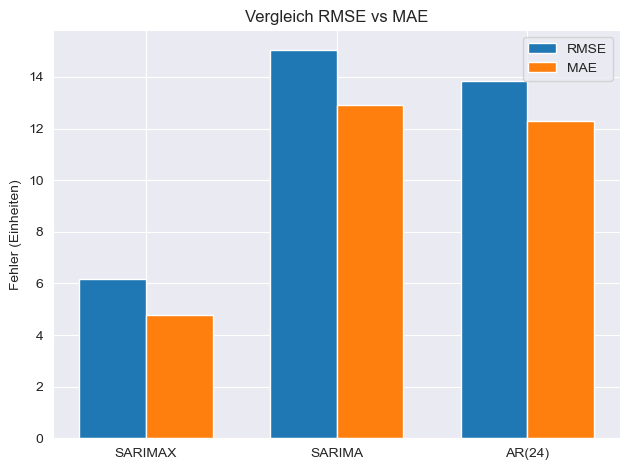

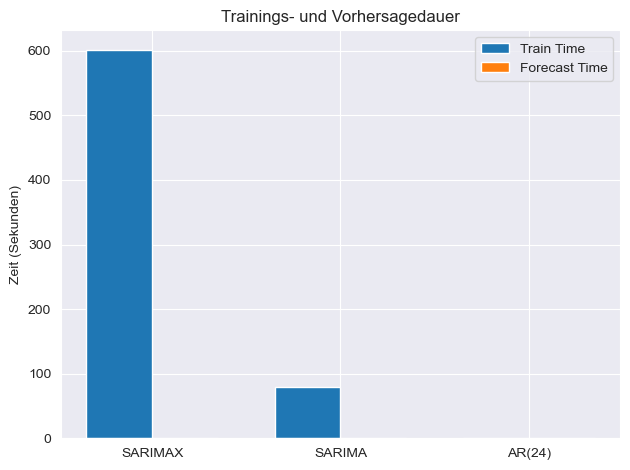

In [15]:
models = cmp['Model']
x = np.arange(len(models))
width = 0.35

# 5) Plot 1: Fehlermetriken
plt.figure()
plt.bar(x - width/2, cmp['RMSE'], width)
plt.bar(x + width/2, cmp['MAE'], width)
plt.xticks(x, models)
plt.ylabel('Fehler (Einheiten)')
plt.title('Vergleich RMSE vs MAE')
plt.legend(['RMSE','MAE'])
plt.tight_layout()
plt.show()

# 6) Plot 2: Laufzeiten
plt.figure()
plt.bar(x - width/2, cmp['Train Time (s)'], width)
plt.bar(x + width/2, cmp['Forecast Time (s)'], width)
plt.xticks(x, models)
plt.ylabel('Zeit (Sekunden)')
plt.title('Trainings- und Vorhersagedauer')
plt.legend(['Train Time','Forecast Time'])
plt.tight_layout()
plt.show()